# Introduction

In this lab, we will learn how to transform features into a higher dimensional, sparse space using an ensemble of trees. We will then train a linear model on these features. We will use different types of ensemble methods including Random Forest and Gradient Boosting and compare their performance.

# Data Preparation

First, we will create a large dataset of 80,000 samples and split it into three sets:

- A set to train the ensemble methods which are later used to as a feature engineering transformer
- A set to train the linear model
- A set to test the linear model.

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

X, y = make_classification(n_samples=80_000, random_state=10)

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

X_train_ensemble, X_train_linear, y_train_ensemble, y_train_linear = train_test_split(X_full_train, y_full_train, test_size=0.5, random_state=42)

# Training Ensemble Methods

For each of the ensemble methods, we will use 10 estimators and a maximum depth of 3 levels.

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

n_estimators = 10
max_depth = 3

random_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

random_forest.fit(X_train_ensemble, y_train_ensemble)

gradient_boosting = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

_ = gradient_boosting.fit(X_train_ensemble, y_train_ensemble)

# Training Embedding Transformer

The **RandomTreesEmbedding** is an unsupervised method and does not require to be trained independently.

In [4]:
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

random_tree_embedding = RandomTreesEmbedding(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

rt_model = make_pipeline(random_tree_embedding, LogisticRegression(max_iter=1000))
rt_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('randomtreesembedding',
                 RandomTreesEmbedding(max_depth=3, n_estimators=10,
                                      random_state=42)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

# Transforming Features with Random Forest and Gradient Boosting

Now, we will create two pipelines that will use the above embedding as a preprocessing stage. The feature transformation will happen by calling the method **apply**. We will then pipeline random forest or gradient boosting with a logistic regression. However, the pipeline in scikit-learn expects a call to **transform**. Therefore, we wrapped the call to **apply** within a **FunctionTransformer**.

In [5]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

def rf_apply(X, model):
    return model.apply(X)

rf_leaves_yielder = FunctionTransformer(rf_apply, kw_args={'model': random_forest})

rf_model = make_pipeline(
    rf_leaves_yielder,
    OneHotEncoder(handle_unknown='ignore'),
    LogisticRegression(max_iter=1000),
)

rf_model.fit(X_train_linear, y_train_linear)

def gbdt_apply(X, model):
    return model.apply(X)[:, :, 0]

gbdt_leaves_yielder = FunctionTransformer(
    gbdt_apply, kw_args={'model': gradient_boosting}
)

gbdt_model = make_pipeline(
    gbdt_leaves_yielder,
    OneHotEncoder(handle_unknown='ignore'),
    LogisticRegression(max_iter=1000),
)
gbdt_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function gbdt_apply at 0x11f03f9c0>,
                                     kw_args={'model': GradientBoostingClassifier(n_estimators=10,
                                                                                  random_state=42)})),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

# Evaluating Models

We can finally show the different ROC curves for all the models

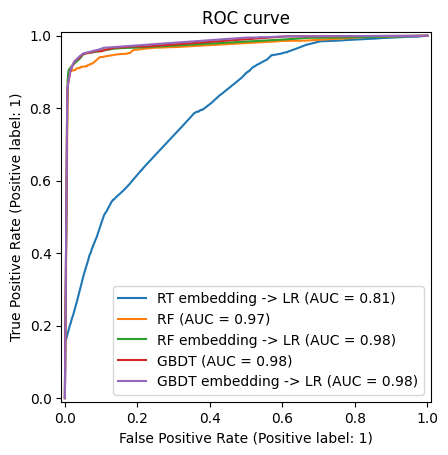

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()

models = [
    ('RT embedding -> LR', rt_model),
    ('RF', random_forest),
    ('RF embedding -> LR', rf_model),
    ('GBDT', gradient_boosting),
    ('GBDT embedding -> LR', gbdt_model),
]

model_displays = {}
for name, pipeline in models:
    model_displays[name] = RocCurveDisplay.from_estimator(
        pipeline, X_test, y_test, ax=ax, name=name
    )

_ = ax.set_title('ROC curve')

# Summary

In this lab, we learned how to transform features into a higher dimensional, sparse space using an ensemble of trees. We used different types of ensemble methods including Random Forest and Gradient Boosting and compared their performance. The **RandomTreesEmbedding** is an unsupervised method and does not require to be trained independently. We also learned how to pipeline random forest or gradient boosting with a logistic regression using the **FunctionTransformer**. Finally, we evaluated the performance of all the models using ROC curves.